First, lets import all necessary modules, including Matplotlib for plotting

Also, define parameters for plotting, including colors

In [62]:
import os
import sys
import math
import copy

if sys.platform=="cygwin":
    from cyglibra_core import *
elif sys.platform=="linux" or sys.platform=="linux2":
    from liblibra_core import *

from libra_py import units
import libra_py.workflows.nbra.step4 as step4


import matplotlib.pyplot as plt   # plots
%matplotlib inline 

plt.rc('axes', titlesize=24)      # fontsize of the axes title
plt.rc('axes', labelsize=20)      # fontsize of the x and y labels
plt.rc('legend', fontsize=20)     # legend fontsize
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels

plt.rc('figure.subplot', left=0.2)
plt.rc('figure.subplot', right=0.95)
plt.rc('figure.subplot', bottom=0.13)
plt.rc('figure.subplot', top=0.88)

colors = {}

colors.update({"11": "#8b1a0e"})  # red       
colors.update({"12": "#FF4500"})  # orangered 
colors.update({"13": "#B22222"})  # firebrick 
colors.update({"14": "#DC143C"})  # crimson   

colors.update({"21": "#5e9c36"})  # green
colors.update({"22": "#006400"})  # darkgreen  
colors.update({"23": "#228B22"})  # forestgreen
colors.update({"24": "#808000"})  # olive      

colors.update({"31": "#8A2BE2"})  # blueviolet
colors.update({"32": "#00008B"})  # darkblue  

colors.update({"41": "#2F4F4F"})  # darkslategray

Here is where we define our model. For this model, we can denerate the Hvib matrices along the pre-computed trajectories (the NBRA assumption). NBRA = neglect of back-reaction approximation. 

In this example, we only imagine a system evolving in time such that the adiabatic energies and non-adiabatic couplings are constant for all times - really the simplest model problem. Well, in reality, this may be not that simple to realise, but we don't care here.

We generate a single data set (one "trajectory") - that's why len(Hvib) == 1 

The trajectory comprises nsteps = 1000 nuclear timesteps

Adiabatic energy levels are at -0.001 and 0.001 a.u. and the NAC is at 0.001 a.u. as well

In [63]:
def expH(H, dt):
    """
    Compute exp(-i*H*dt/hbar), hbar = 1
    """
    
    N = H.num_of_cols
    I = CMATRIX(N,N); I.identity()
    
    U, S, V = CMATRIX(N,N), CMATRIX(N,N), CMATRIX(N,N)
    
    JacobiSVD_decomposition(H, U, S, V)
    
    # H = U * S * V.H()
    expS = CMATRIX(N,N)
    
    for i in xrange(N):
        argg = -S.get(i,i).real*dt        
        expS.set(i,i, math.cos(argg), math.sin(argg))
        
    res = U * expS * V.H()
    
    return res


In [64]:
def compute_dyn(H, Coeff, params):
    nstates = Coeff.num_of_rows
    nsteps = params["nsteps"]
    dt = params["dt"]
    
    C = CMATRIX(Coeff)
    
    res = MATRIX(nsteps, 1+nstates*2)
    
    
    for i in xrange(nsteps):        
        D = C * C.H()
        norm = D.tr().real
        
        res.set(i, 0, dt*i)
        for j in xrange(nstates):
            res.set(i, 1+j, D.get(j,j).real)
            
            if norm>0.0:
                res.set(i, 1+nstates+j, D.get(j,j).real/norm)
            else:
                res.set(i, 1+nstates+j, 0.0)
        
        C = expH(H[i], dt) * C
    
    return res    

In [65]:
nsteps = 100

# Populate Hvib - this is our model
Hvib = []
hvib = []
for i in xrange(nsteps):
    hvib.append(CMATRIX(2,2))
    hvib[i].set(0,0, 0.0+0.0j);    hvib[i].set(0,1, 0.0+0.0001j);
    hvib[i].set(1,0, 0.0-0.0001j);   hvib[i].set(1,1, 0.001+0.0j);
Hvib.append(hvib)

In [66]:
Coeff = CMATRIX(2,1)
Coeff.set(0,0, 0.0+0.0j)
Coeff.set(1,0, 1.0+0.0j)

params = {"nsteps":nsteps, "dt":41.0}

res = compute_dyn(Hvib[0], Coeff, params)

We can also to an arbitrary scaling of the Hamiltonian.

Uncomment the line in the code below to increase the gap by 0.1 and multiply the coupling by a factor of 3

In [67]:
t = []
P0, P1 = [], []
nP0, nP1 = [], []
for i in xrange(nsteps):
    t.append(res.get(i, 0)*units.au2fs )  # time
    P0.append(res.get(i, 1))  # raw pop of state 0
    P1.append(res.get(i, 2))  # raw pop of state 1
    nP0.append(res.get(i, 3))  # normalized pop of state 0
    nP1.append(res.get(i, 4))  # normalized pop of state 1

Finally, we can plot the results. 

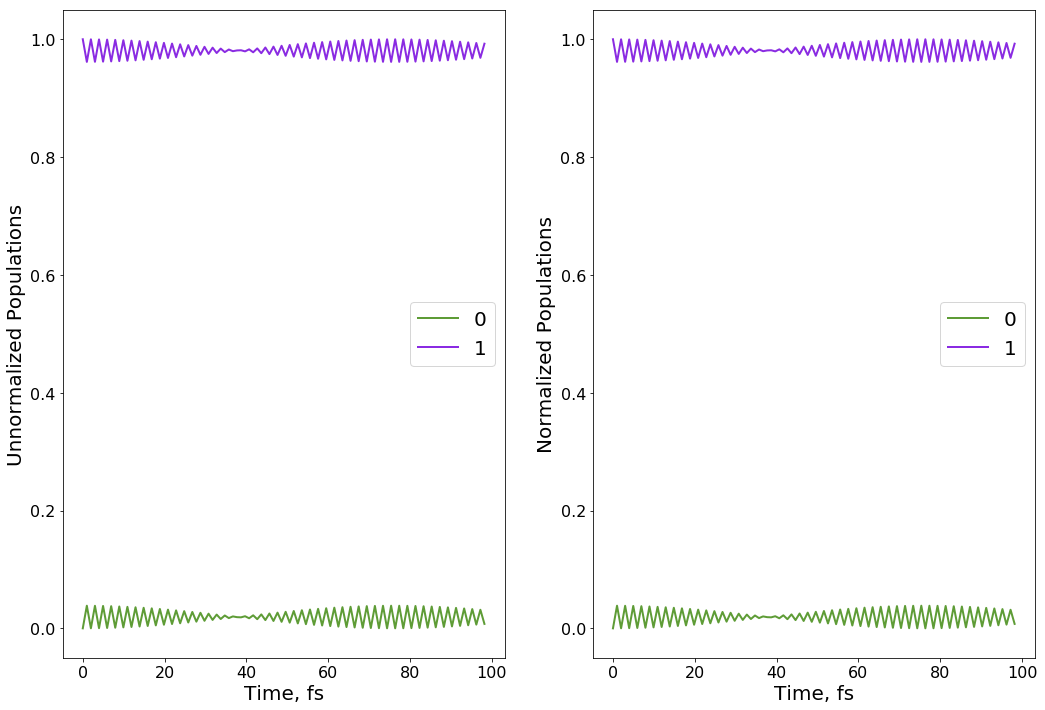

In [68]:
plt.figure(1, figsize=(18, 12)) # dpi=300, frameon=False)
plt.subplot(1,2,1)
plt.xlabel('Time, fs')
plt.ylabel('Unnormalized Populations')
plt.plot(t, P0, label='0', linewidth=2, color = colors["21"]) 
plt.plot(t, P1, label='1', linewidth=2, color = colors["31"]) 
plt.legend()

plt.subplot(1,2,2)
plt.xlabel('Time, fs')
plt.ylabel('Normalized Populations')
plt.plot(t, nP0, label='0', linewidth=2, color = colors["21"]) 
plt.plot(t, nP1, label='1', linewidth=2, color = colors["31"]) 
plt.legend()

plt.show()
plt.close()

In [69]:
D = Coeff * Coeff.H()
print D.get(0,0).real, D.get(1,1).real

0.0 1.0


In [70]:
dt = 1.0

hvib = CMATRIX(2,2)
hvib.set(0,0, 0.0+0.0j);     hvib.set(0,1, 0.0+0.0001j);
hvib.set(1,0, 0.0-0.0001j);   hvib.set(1,1, 0.003+0.0j);

C = expH(hvib, dt) * Coeff

D = C * C.H()
print D.get(0,0).real, D.get(1,1).real

0.00442476880532 0.995575231195
